In [1]:
from tensorflow import keras
from tensorflow.keras import layers

import json
import numpy as np
import tensorflow as tf

IMG_DIR = 'images'

Take a look at my poor little CPU ¯\\_(ツ)_/¯

In [2]:
from subprocess import Popen, PIPE

process = Popen(['nvidia-smi'], stdout=PIPE)
(output, err) = process.communicate()
exit_code = process.wait()
print(output.decode('utf8'))

Thu Dec  9 17:42:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 496.13       Driver Version: 496.13       CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0 Off |                  N/A |
| N/A   42C    P8    N/A /  N/A |     64MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
with open('settings.json') as f:
    settings = json.load(f)

In [5]:
seed = 666
image_size = (256, 256)
# Size to resize images to after they are read from disk.
# Defaults to (256, 256). Since the pipeline processes batches
# of images that must all have the same size, this must be provided. 
batch_size = 8
# my poor laptop GPU won't support any size larger...
validation_split=0.33
# float between 0 and 1, fraction of data to reserve for validation. 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_DIR,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=IMG_DIR,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

Found 26179 files belonging to 10 classes.
Using 17540 files for training.
Found 26179 files belonging to 10 classes.
Using 8639 files for validation.


InvalidArgumentError: slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

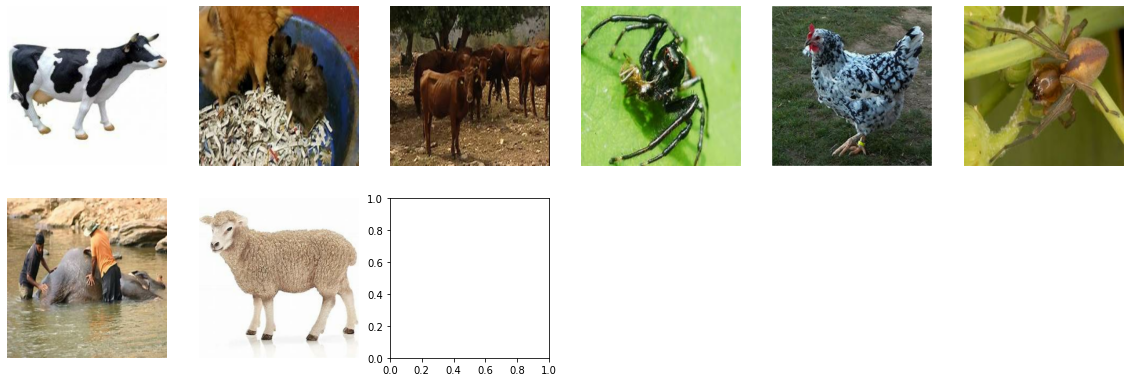

In [8]:
# Visualize the data
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(settings['labels'][int(labels[i])])
        plt.axis("off")

When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

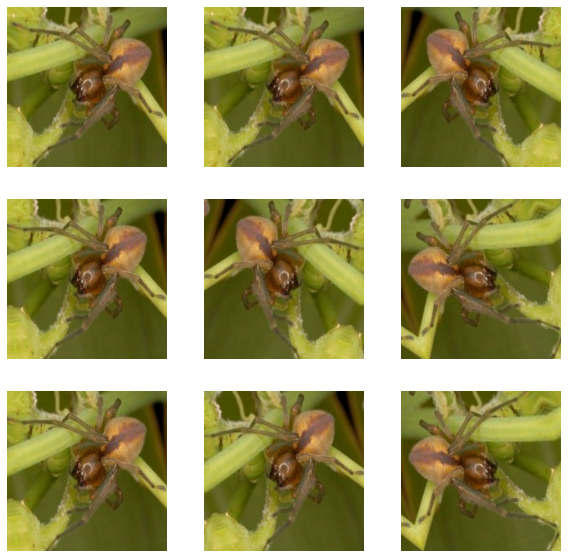

In [9]:
data_augmentation = keras.Sequential(
    layers=[layers.RandomFlip("horizontal"), layers.RandomRotation(0.1)]
)
# Sequential groups a linear stack of layers into a tf.keras.Model.
# Layers are the basic building blocks of neural networks in Keras.
# A layer consists of a tensor-in tensor-out computation function
# (the layer's call method) and some state, held in TensorFlow variables (the layer's weights).
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

In [11]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # The inputs that is returned contains information about the shape and dtype of the input data that you feed to your model.
    
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=len(settings['labels']))

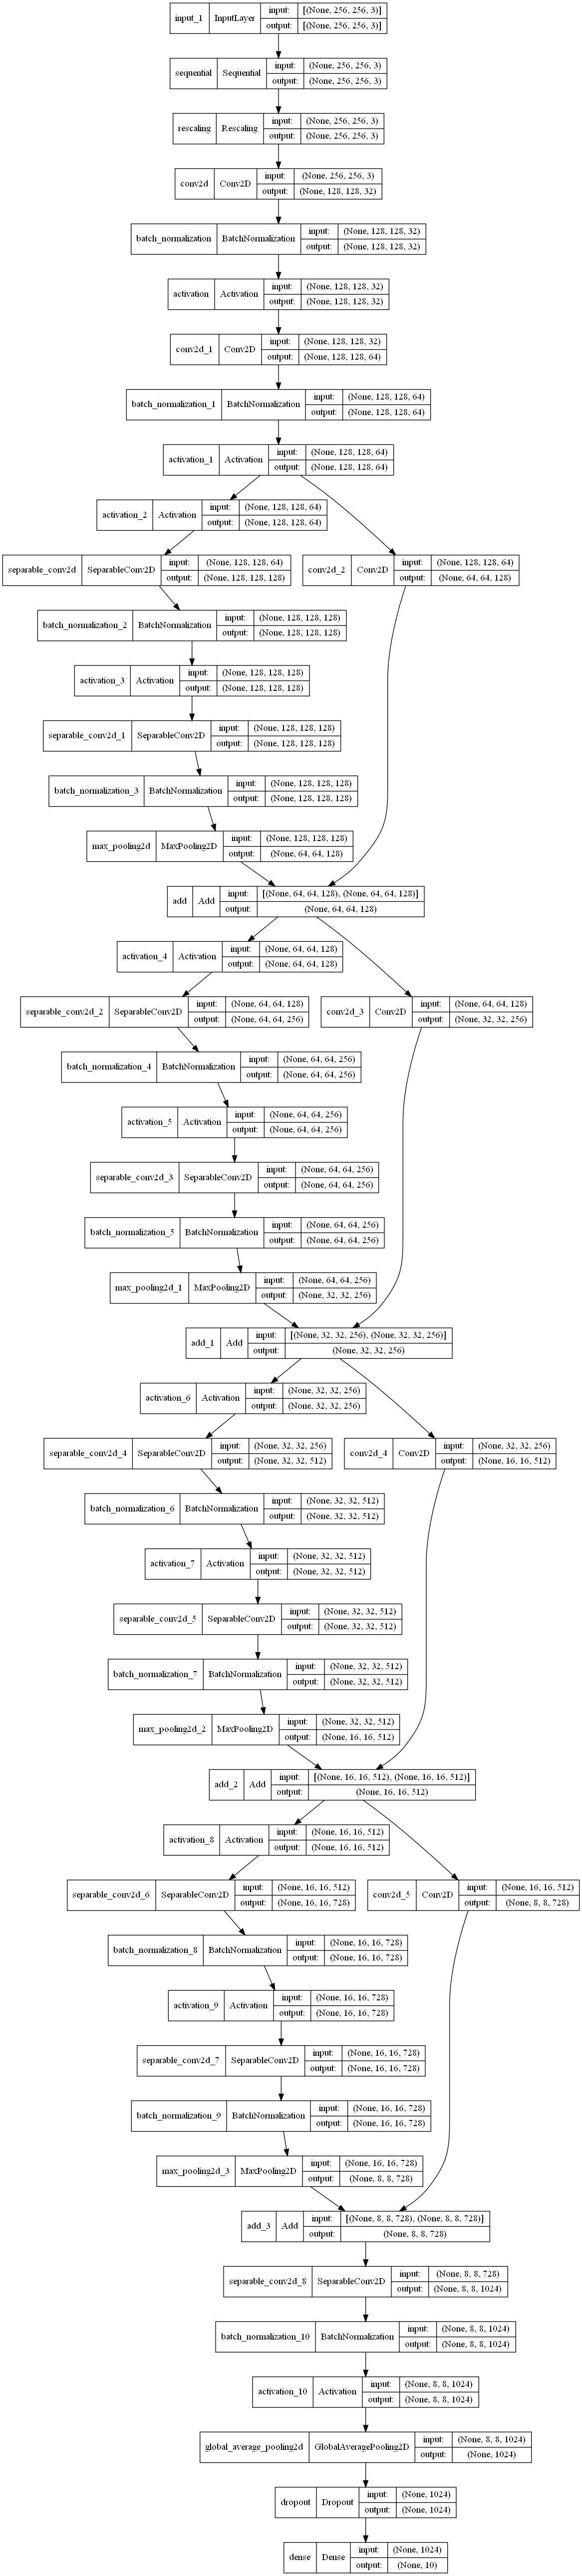

In [12]:
keras.utils.plot_model(model, show_shapes=True)

In [17]:
epochs = 50

callbacks = [
  #  keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)
model.fit(train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
2193/2193 [==============================] - 1305s 595ms/step - loss: 1.9613 - sparse_categorical_accuracy: 0.3168 - val_loss: 2.0052 - val_sparse_categorical_accuracy: 0.3228
Epoch 2/50
2193/2193 [==============================] - 1339s 611ms/step - loss: 1.6434 - sparse_categorical_accuracy: 0.4327 - val_loss: 1.4845 - val_sparse_categorical_accuracy: 0.4958
Epoch 3/50
2193/2193 [==============================] - 1351s 616ms/step - loss: 1.4263 - sparse_categorical_accuracy: 0.5042 - val_loss: 2.9672 - val_sparse_categorical_accuracy: 0.3026
Epoch 4/50
2193/2193 [==============================] - 1341s 611ms/step - loss: 1.2876 - sparse_categorical_accuracy: 0.5598 - val_loss: 1.1748 - val_sparse_categorical_accuracy: 0.5995
Epoch 5/50
2193/2193 [==============================] - 1360s 620ms/step - loss: 1.1535 - sparse_categorical_accuracy: 0.6067 - val_loss: 1.2884 - val_sparse_categorical_accuracy: 0.5697
Epoch 6/50
2193/2193 [==============================] - 1380s 629

KeyboardInterrupt: 